<a href="https://colab.research.google.com/github/DengChiung/kmuh20231206/blob/main/kmncnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

深度學習兩大函式庫
1. tensorflow
2. PyTorch

In [ ]:
# rarfile: 第三方,colab預測沒有
!pip install rarfile
import rarfile
# 解壓縮到這次的機器
fn = "drive/My Drive/xray_dataset_covid19.rar"
rarfile.RarFile(fn).extractall()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# 資料增強: zoom:放大(1.2) shear:偏斜(0.2) 水平翻轉
train_datagen = ImageDataGenerator(
    rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)
# 測試資料是沒有動的
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    "./xray_dataset_covid19/train",
    # 每一張圖片都縮到(112, 112)
    target_size=(112, 112),
    # 一次給我32張
    batch_size=32,
    class_mode="sparse",
    # 轉成灰階
    color_mode="grayscale"
)
test_set = test_datagen.flow_from_directory(
    "./xray_dataset_covid19/test",
    target_size=(112, 112),
    batch_size=32,
    class_mode="sparse",
    color_mode="grayscale"
)

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


(32, 112, 112, 1)


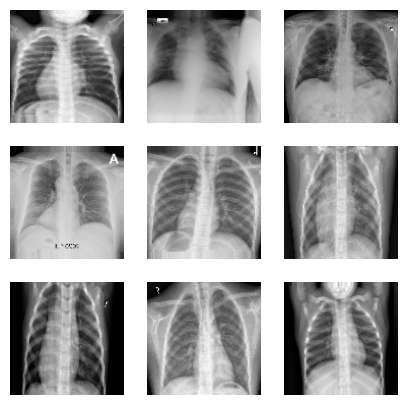

In [ ]:
# 秀出訓練資料被數據增強以後產生的圖片
import matplotlib.pyplot as plt
batch = training_set.__next__()[0]
print(batch.shape)
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[i], cmap="gray")
    plt.axis("off")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense

layers = [
    # 64: 64種過濾方式, 3: 3 * 3:移動窗口大小
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(112, 112, 1)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    # 把14 * 14-> 濃縮成一個平均值
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(layers)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 256)     

In [ ]:
# loss: 目前預測值和正確答案距離
# 深度學習只有一個目的: loss min
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer=Adam(),
       metrics=["accuracy"])


In [ ]:
# 控制訓練次數: 控制過擬合程度
# 不希望死背/看稀少, 檢查test
# 訓練次數過多反而會變差
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
    ModelCheckpoint("cnn.h5", save_best_only=True),
    # 檢查test資料, 如果我10次都沒有表現更好, 停
    EarlyStopping(patience=10, restore_best_weights=True)
]
# 不想要進度條, verbose=2
model.fit(training_set,
     epochs=150,
     validation_data=test_set,
     callbacks=callbacks,
     verbose=2)

Epoch 1/150
5/5 - 18s - loss: 0.7170 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000 - 18s/epoch - 4s/step
Epoch 2/150
5/5 - 5s - loss: 0.6933 - accuracy: 0.4392 - val_loss: 0.6886 - val_accuracy: 0.8500 - 5s/epoch - 1s/step
Epoch 3/150
5/5 - 6s - loss: 0.6915 - accuracy: 0.5946 - val_loss: 0.6820 - val_accuracy: 0.7250 - 6s/epoch - 1s/step
Epoch 4/150
5/5 - 5s - loss: 0.6868 - accuracy: 0.5811 - val_loss: 0.6678 - val_accuracy: 0.5000 - 5s/epoch - 1s/step
Epoch 5/150
5/5 - 7s - loss: 0.6813 - accuracy: 0.6014 - val_loss: 0.6479 - val_accuracy: 0.9000 - 7s/epoch - 1s/step
Epoch 6/150
5/5 - 5s - loss: 0.6754 - accuracy: 0.6622 - val_loss: 0.6217 - val_accuracy: 0.5000 - 5s/epoch - 1s/step
Epoch 7/150
5/5 - 7s - loss: 0.6699 - accuracy: 0.5811 - val_loss: 0.5978 - val_accuracy: 0.9500 - 7s/epoch - 1s/step
Epoch 8/150
5/5 - 5s - loss: 0.6396 - accuracy: 0.6757 - val_loss: 0.5266 - val_accuracy: 0.8000 - 5s/epoch - 1s/step
Epoch 9/150
5/5 - 6s - loss: 0.6226 - accuracy: 0.6757

給你看一下每一個過濾器到底對原圖的哪裡產生反應

In [ ]:
# 挑出一張正常/確診
import glob
from PIL import Image
normal = glob.glob("xray_dataset_covid19/test/NORMAL/*")[0]
pneumonia = glob.glob("xray_dataset_covid19/test/PNEUMONIA/*")[0]
normal = Image.open(normal).convert("L").resize((112, 112))
pneumonia = Image.open(pneumonia).convert("L").resize((112, 112))

In [ ]:
import numpy as np
normal = np.array(normal).reshape(1, 112, 112, 1) / 255.0
pneumonia = np.array(pneumonia).reshape(1, 112, 112, 1) / 255.0

1/1 [==============================] - 0s 83ms/step


<ipython-input-24-594e6ebde466>:8: RuntimeWarning: invalid value encountered in true_divide
  filter1 = (filter1 - mi) / (ma - mi)


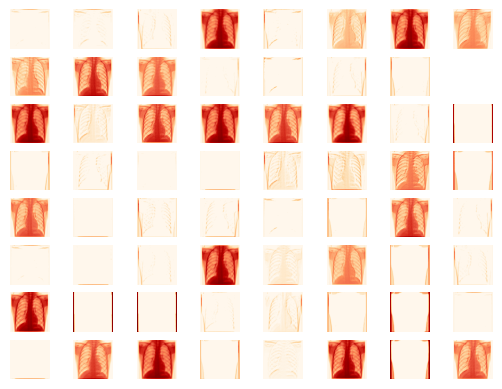

In [ ]:
# 正常的那張, 第一層過濾器對圖的那些地方產生反應. 越紅色反應越強
test = Sequential(model.layers[0])
test_pre = test.predict(normal)[0]
for i in range(test_pre.shape[-1]):
    filter1 = test_pre[:, :, i]
    ma = filter1.max(axis=(0, 1))
    mi = filter1.min(axis=(0, 1))
    filter1 = (filter1 - mi) / (ma - mi)
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(filter1, cmap="OrRd")

1/1 [==============================] - 0s 43ms/step


<ipython-input-25-0177ebd905f7>:7: RuntimeWarning: invalid value encountered in true_divide
  filter1 = (filter1 - mi) / (ma - mi)


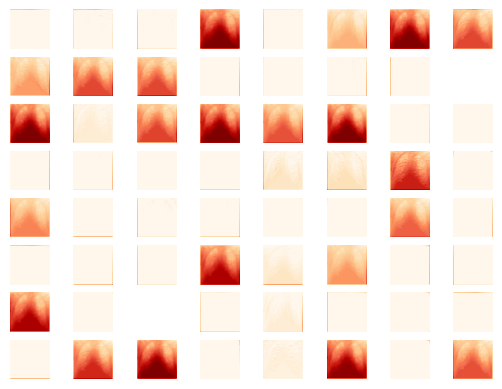

In [ ]:
test = Sequential(model.layers[0])
test_pre = test.predict(pneumonia)[0]
for i in range(test_pre.shape[-1]):
    filter1 = test_pre[:, :, i]
    ma = filter1.max(axis=(0, 1))
    mi = filter1.min(axis=(0, 1))
    filter1 = (filter1 - mi) / (ma - mi)
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(filter1, cmap="OrRd")